In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-4o",temperature=0.3)

In [3]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated, List, Optional

class UserProfile(BaseModel):
    """
    User profile information captured during onboarding.
    This will be stored in memory and used for personalization.
    """

    name: str = Field(..., description="User's preferred name")
    target_language: str = Field(..., description="Language the user wants to learn")
    proficiency_level: Literal["begineer", "intermediate", "advanced"] = Field(
        ..., 
        description="User's self-assessed proficiency level in the target language"
    )
    topic_interests: Optional[List[str]] = Field(
        [], 
        description="Topics the user is interested in learning vocabulary for"
    )
    learning_goals: Optional[List[str]] = Field(
        [], 
        description="User's goals for learning the language"
    )

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

user_profile_system_prompt = """You are an onboarding assistant helping to collect user information. 
Your goal is to gather a complete details from the user.

If you have enough information to complete the UserInfo, use the tool to extract the information. If information is incomplete, ask clarifying questions to the user.
Don't answer any other queries not related to collecting user information. Try to collect the details withing 3 conversation turns.
"""

user_profile_prompt_template = ChatPromptTemplate.from_messages([("system", user_profile_system_prompt), MessagesPlaceholder(variable_name="messages")])

user_profile_llm = llm.bind_tools([UserProfile])

user_profile_chain = user_profile_prompt_template | user_profile_llm

In [5]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import PydanticToolsParser

parser = PydanticToolsParser(tools=[UserProfile])

max_iterations = 5
messages = [HumanMessage(content="Hi. What are informations do you need from me?")]
for iteration in range(max_iterations):
    response = user_profile_chain.invoke({
        "messages": messages
    })
    messages.append(response)
    if(response.tool_calls):
        break
    else:
        print('AI Message:', response.content)
        current_user_input = input("Enter q or Q to exit. Enter your message: ")
        if(current_user_input.lower() == 'q'):
            break
        messages.append(HumanMessage(content=current_user_input))
        print('Human Message:', current_user_input)

AI Message: I need to gather the following information from you:

1. Your preferred name.
2. The language you want to learn.
3. Your self-assessed proficiency level in the target language (beginner, intermediate, or advanced).
4. Topics you are interested in learning vocabulary for (optional).
5. Your goals for learning the language (optional).

Could you please provide these details?
Human Message: Hello I am Kirushi, i want to learn hindi because next month i am going to delhi so that i can communicate with the locals there better to get things done
AI Message: Great, Kirushi! I have a few more questions to complete your profile:

1. What is your self-assessed proficiency level in Hindi? (beginner, intermediate, or advanced)
2. Are there any specific topics you are interested in learning vocabulary for? (optional)

Once I have this information, I'll be able to complete your profile.
Human Message: I am new to hindi and specific topics in the sense i want to learn about general words 

In [6]:
try:
    structured_output = parser.invoke(messages[-1])[0]
except:
    structured_output = UserProfile(name="John Doe", target_language="Hindi", proficiency_level="intermediate")

structured_output

UserProfile(name='Kirushi', target_language='Hindi', proficiency_level='begineer', topic_interests=['general words', 'day to day activities'], learning_goals=['communicate with locals in Delhi'])

In [7]:
import uuid
from langgraph.store.memory import InMemoryStore
from langmem import create_memory_store_manager

store = InMemoryStore(
    index={"embed": embeddings}
)


store.put(
    ("vocab_assistant", structured_output.name, "profile"), 
    str(uuid.uuid4()), 
    structured_output.model_dump()
)

In [8]:
results = store.search(
    ("vocab_assistant", "Kirushi", "profile"),
    query="Kirushi",
    limit=1,
)

results

[Item(namespace=['vocab_assistant', 'Kirushi', 'profile'], key='d866ec7e-87e0-4817-8e72-451001bcfb07', value={'name': 'Kirushi', 'target_language': 'Hindi', 'proficiency_level': 'begineer', 'topic_interests': ['general words', 'day to day activities'], 'learning_goals': ['communicate with locals in Delhi']}, created_at='2025-03-24T05:39:48.861357+00:00', updated_at='2025-03-24T05:39:48.861365+00:00', score=0.4019875355610005)]

In [9]:
from langchain_core.tools import tool
from prompts import vocabulary_human_prompt

@tool
def introduce_vocabulary(topic: str = None, difficulty: str = "easy", count: int = 5, target_language: str = "Hindi") -> str:
    """
    Introduce new vocabulary words in the target language based on topic and difficulty.
    
    Args:
        topic: The topic or category for vocabulary (e.g., greetings, food, travel)
        difficulty: The difficulty level (easy, medium, hard)
        count: Number of words to introduce
        target_language: The language to teach (defaults to Hindi)
        
    Returns:
        Formatted vocabulary list with translations and example sentences
    """
    topic = topic or "greetings"  # Default to greetings if no topic specified
    
    # Use LLM to generate vocabulary based on parameters
    vocabulary_prompt = vocabulary_human_prompt.format(topic=topic, count=count, difficulty=difficulty, target_language=target_language)
    
    # Call the LLM to generate dynamic vocabulary
    vocabulary_response = llm.invoke(vocabulary_prompt)
    
    # Format the response
    result = f"Here are {count} {difficulty} vocabulary words about {topic} in {target_language}:\n\n"
    result += vocabulary_response.content
    
    return result

In [10]:
print(introduce_vocabulary.invoke({"topic": "greetings", "count": 5, "difficulty": "easy", "target_language": "Hindi"}))

Here are 5 easy vocabulary words about greetings in Hindi:

1. Word: नमस्ते
   Transliteration: Namaste
   Translation: Hello
   Example: नमस्ते, आप कैसे हैं?
   Example Translation: Hello, how are you?
   Usage Note: "Namaste" is a common greeting in India, used both when meeting and parting. It is often accompanied by a slight bow and hands pressed together in front of the chest.

2. Word: अलविदा
   Transliteration: Alvida
   Translation: Goodbye
   Example: अलविदा, फिर मिलेंगे।
   Example Translation: Goodbye, we will meet again.
   Usage Note: "Alvida" is used to bid farewell. It is less formal than "विदा" (vida) and is commonly used in casual conversations.

3. Word: धन्यवाद
   Transliteration: Dhanyavaad
   Translation: Thank you
   Example: आपके मदद के लिए धन्यवाद।
   Example Translation: Thank you for your help.
   Usage Note: "Dhanyavaad" is a formal way to express gratitude. In casual settings, "शुक्रिया" (shukriya) is also used.

4. Word: स्वागत
   Transliteration: Swagat
  

In [11]:
from prompts import exercise_human_prompt

@tool
def create_practice_exercise(exercise_type: str, difficulty: str = "beginner", topic: str = "general", target_language: str = "Hindi", recent_vocabulary: str = None) -> str:
    """
    Create a practice exercise for language learning using LLM.
    
    Args:
        exercise_type: Type of exercise (translation, fill-blank, multiple-choice, matching, conversation)
        difficulty: Difficulty level (beginner, intermediate, advanced)
        topic: Topic area for the exercise (e.g., travel, food, family)
        target_language: The language being learned
        recent_vocabulary: Recently introduced vocabulary to incorporate (optional)
        
    Returns:
        A formatted practice exercise
    """
    # Create a prompt for the LLM to generate a custom exercise
    exercise_prompt = exercise_human_prompt.format(
        difficulty=difficulty,
        exercise_type=exercise_type,
        topic=topic,
        target_language=target_language
    )
    
    # Add recent vocabulary if provided
    if recent_vocabulary:
        exercise_prompt += f"\nPlease incorporate these recently learned vocabulary items where appropriate: {recent_vocabulary}"
    
    # Call the LLM to generate a custom exercise
    exercise_response = llm.invoke(exercise_prompt)
    
    return exercise_response.content

In [12]:
print(create_practice_exercise.invoke({"exercise_type": "fill_in_the_blank", "difficulty": "easy", "topic": "travel", "target_language": "Hindi"}))

**Fill in the Blank Exercise: Travel in Hindi**

**Instructions:** Fill in the blanks with the appropriate Hindi words related to travel. Use the context of the sentence to help you choose the correct word. An example is provided for the first item.

---

1. मैं ___________ से दिल्ली जा रहा हूँ।  
   (Example answers: ट्रेन, बस, हवाई जहाज)

2. हम ___________ में ठहरेंगे।  
   (Options: होटल, घर, शिविर)

3. ___________ कितने बजे है?  
   (Options: ट्रेन, बस, उड़ान)

4. मुझे ___________ चाहिए।  
   (Options: टिकट, पासपोर्ट, वीज़ा)

5. ___________ कहाँ है?  
   (Options: रेलवे स्टेशन, हवाई अड्डा, बस स्टॉप)

---

**Answer Key:**

1. मैं **ट्रेन** से दिल्ली जा रहा हूँ।
2. हम **होटल** में ठहरेंगे।
3. **ट्रेन** कितने बजे है?
4. मुझे **टिकट** चाहिए।
5. **रेलवे स्टेशन** कहाँ है?


In [13]:
from prompts import assessment_human_prompt

@tool
def assess_user_response(exercise: str, user_answers: List[str], target_language: str = "Hindi", proficiency_level: str = "beginner") -> str:
    """
    Assess the user's responses to an exercise using LLM.
    
    Args:
        exercise: The full exercise content including questions and correct answers
        user_answers: List of user's answers to each question
        target_language: The language being learned
        proficiency_level: User's proficiency level (beginner, intermediate, advanced)
        
    Returns:
        Detailed feedback on the user's answers with explanations
    """
    # Create a prompt for the LLM to assess the answers
    
    assessment_prompt = assessment_human_prompt.format(
        exercise=exercise,
        user_answers=user_answers,
        target_language=target_language,
        proficiency_level=proficiency_level,
    )
    # Call the LLM to generate detailed assessment feedback
    assessment_response = llm.invoke(assessment_prompt)
    
    return assessment_response.content

In [14]:
assessment_result = assess_user_response.invoke({
    "exercise": """
Translate the following English phrases to Hindi:
1. Hello, how are you? - नमस्ते, आप कैसे हैं?
2. My name is John - मेरा नाम जॉन है
3. Where is the hotel? - होटल कहां है?
4. I like Indian food - मुझे भारतीय खाना पसंद है
5. Thank you very much - आपका बहुत धन्यवाद
""",
    "user_answers": [
        "नमस्ते, आप कैसे हो?",
        "मेरा नाम John है",
        "होटल कहां है?",
        "मुझे Indian खाना पसंद है",
        "धन्यवाद"
    ],
    "target_language": "Hindi",
    "proficiency_level": "beginner"
})

print(assessment_result)

Sure! Let's go through each of your answers and see how you did. 😊

1. **Hello, how are you?**
   - Your Answer: 'नमस्ते, आप कैसे हो?'
   - Assessment: ⚠️ Partially Correct
   - Explanation: You used "कैसे हो?" which is informal and typically used for friends or people you are familiar with. The exercise uses "कैसे हैं?" which is more formal and polite.
   - Correct Answer: 'नमस्ते, आप कैसे हैं?'
   - Tip: In Hindi, the level of formality is important. Use "हैं" for formal situations and "हो" for informal ones.

2. **My name is John**
   - Your Answer: 'मेरा नाम John है'
   - Assessment: ⚠️ Partially Correct
   - Explanation: You mixed Hindi and English scripts. It's important to stay consistent with the script you choose.
   - Correct Answer: 'मेरा नाम जॉन है'
   - Tip: Try to use the Devanagari script for Hindi words to improve your reading and writing skills in Hindi.

3. **Where is the hotel?**
   - Your Answer: 'होटल कहां है?'
   - Assessment: ✅ Correct
   - Explanation: Great job

In [15]:
from prompts import scheduling_human_prompt

@tool
def schedule_review(words: List[dict], user_performance: dict = None, user_history: dict = None) -> str:
    """
    Schedule words for spaced repetition review using LLM intelligence.
    
    Args:
        words: List of words with their metadata (word, confidence, last_reviewed, review_count)
        user_performance: Data about the user's past performance with these words
        user_history: User's learning history and patterns
        
    Returns:
        Spaced repetition schedule with explanation
    """
    # Create a prompt for the LLM to generate a spaced repetition schedule
    
    scheduling_prompt = scheduling_human_prompt.format(
        words=words,
        user_performance=user_performance if user_performance else "User's past performance data not available yet",
        user_history=user_history if user_history else "User's learning history not available yet"
    )
    # Call the LLM to generate an intelligent spaced repetition schedule
    schedule_response = llm.invoke(scheduling_prompt)
    
    return schedule_response.content

In [16]:
schedule_result = schedule_review.invoke({
    "words": [
        {"word": "नमस्ते", "confidence": 0.9, "last_reviewed": "2023-03-15", "review_count": 5},
        {"word": "धन्यवाद", "confidence": 0.7, "last_reviewed": "2023-03-18", "review_count": 3},
        {"word": "होटल", "confidence": 0.4, "last_reviewed": "2023-03-20", "review_count": 2},
        {"word": "पानी", "confidence": 0.2, "last_reviewed": "2023-03-21", "review_count": 1},
        {"word": "खाना", "confidence": 0.6, "last_reviewed": "2023-03-10", "review_count": 4}
    ],
    "user_performance": {
        "average_retention_rate": 0.65,
        "learning_speed": "moderate",
        "study_frequency": "daily"
    }
})
print("=== SPACED REPETITION SCHEDULE ===")
print(schedule_result)
print("\n\n")

=== SPACED REPETITION SCHEDULE ===
To create an optimal spaced repetition schedule for the language learner, we'll apply the principles of the SuperMemo SM-2 algorithm, taking into account the confidence levels, review counts, and time since the last review for each word. Here's how we'll approach it:

### Scheduling Strategy:

1. **Low Confidence (<0.3):** These words need immediate attention and should be reviewed tomorrow to reinforce memory.
2. **Medium Confidence (0.3-0.7):** These words are somewhat familiar but still need reinforcement. We'll calculate the next review interval using the formula: `next_interval = current_interval * (0.5 + confidence)`.
3. **High Confidence (>0.7):** These words are well-known, so they can be reviewed less frequently. We'll use the formula: `next_interval = current_interval * (1.5 + confidence)`.

The current interval is determined by the time since the last review. We'll calculate the next review date for each word and categorize them into the ap

In [17]:
from prompts import grammar_human_prompt

@tool
def explain_grammar_concept(concept: str, language: str, proficiency_level: str = "beginner", with_examples: bool = True, related_to_interests: str = None) -> str:
    """
    Explain a grammar concept in the target language using LLM.
    
    Args:
        concept: The grammar concept to explain
        language: The target language
        proficiency_level: User's proficiency level
        with_examples: Whether to include examples
        related_to_interests: User's interests to make examples relevant
        
    Returns:
        A detailed explanation of the grammar concept
    """
    # Create a prompt for the LLM to generate a grammar explanation
    
    grammar_prompt = grammar_human_prompt.format(
        concept=concept, 
        language=language, 
        proficiency_level=proficiency_level, 
        with_examples=f"Include at least 5 practical examples showing correct usage, with both {language} script and transliteration" if with_examples else "Keep the explanation brief with minimal examples", 
        related_to_interests=f"The examples should relate to these interests/topics when possible: {related_to_interests}" if related_to_interests else ""
    )
    grammar_response = llm.invoke(grammar_prompt)
    
    return grammar_response.content

In [18]:
grammar_result = explain_grammar_concept.invoke({
    "concept": "verb conjugation",
    "language": "Hindi",
    "proficiency_level": "beginner",
    "with_examples": True,
    "related_to_interests": "travel, food, daily conversation"
})

print(grammar_result)

### Understanding Verb Conjugation in Hindi

Verb conjugation in Hindi involves changing the form of a verb to convey different meanings related to tense, mood, aspect, and the subject's number and gender. This concept is crucial for constructing meaningful sentences in Hindi.

#### 1. Concept Overview

- **Verb conjugation** in Hindi changes the verb form based on:
  - **Tense**: Past, present, future
  - **Aspect**: Simple, continuous, perfect
  - **Number**: Singular, plural
  - **Gender**: Masculine, feminine

#### 2. Comparison with English

- **Similarities**:
  - Both languages change verb forms to indicate tense.
  - Subject-verb agreement is necessary in both languages.

- **Differences**:
  - Hindi verbs change according to gender, which is not the case in English.
  - Hindi has a more extensive system of verb endings to indicate different aspects and moods.

#### 3. Common Patterns or Rules

- **Present Tense**:
  - Masculine Singular: Verb stem + ता (taa)
  - Feminine Singu

In [19]:
# Schema for vocabulary items
class VocabularyItem(BaseModel):
    """Vocabulary item for tracking learning progress."""
    word: str
    translation: str
    example_sentence: str
    notes: str
    difficulty: Literal["easy", "medium", "hard"]
    confidence: float  # 0.0 to 1.0
    next_review: int   # timestamp for next review
    review_count: int  # number of times reviewed

In [20]:
from langmem import create_manage_memory_tool, create_search_memory_tool

manage_memory_tool = create_manage_memory_tool(
    namespace=("vocab_assistant", "{user_id}", "vocabulary"),
    schema=VocabularyItem,
)
search_memory_tool = create_search_memory_tool(
    namespace=("vocab_assistant", "{user_id}", "vocabulary")
)

In [21]:
# List of all tools
tools = [
    introduce_vocabulary,
    create_practice_exercise,
    assess_user_response,
    schedule_review,
    explain_grammar_concept,
    manage_memory_tool,
    search_memory_tool
]

In [22]:
# System prompt for the main agent
main_agent_system_prompt = """
You are a personalized language learning assistant. Your goal is to help the user learn their target language effectively.

User Profile:
- Name: {name}
- Target language: {target_language}
- Current proficiency: {proficiency_level}
- Learning goals: {learning_goals}
- Interests: {interests}
- Preferred learning style: {preferred_learning_style}

You have access to the following tools:
1. introduce_vocabulary - Introduce new vocabulary based on topic and difficulty
2. create_practice_exercise - Create different types of practice exercises
3. assess_user_response - Evaluate the user's answers to exercises
4. schedule_review - Schedule words for spaced repetition review
5. explain_grammar_concept - Explain grammar concepts in the target language
6. manage_memory - Store important information about the user's learning journey
7. search_memory - Retrieve information about past learning sessions

Remember to:
- Be encouraging and supportive
- Adapt to the user's learning pace
- Provide examples relevant to the user's interests
- Use spaced repetition principles for vocabulary
- Store important information using manage_memory
- Retrieve past learning information using search_memory
"""

In [23]:
# Function to create the prompt based on the user's profile
def create_prompt(state, config, store):
    user_id = config['configurable']['user_id']
    
    namespace = ("vocab_assistant", user_id, "profile")
    result = store.search(namespace,limit=1)
    profile = result[0]
    
    return [
        {
            "role": "system",
            "content": main_agent_system_prompt.format(
                name=profile.value.get('name', 'User'),
                target_language=profile.value.get('target_language', 'Hindi'),
                proficiency_level=profile.value.get('proficiency_level', 'beginner'),
                learning_goals=", ".join(profile.value.get('learning_goals', ['Basic conversation'])),
                interests=", ".join(profile.value.get('interests', ['General'])),
                preferred_learning_style=profile.value.get('preferred_learning_style', 'Balanced')
            )
        }
    ] + state.get('messages', [])

In [24]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Create the agent
learning_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=create_prompt,
    store=store,
    checkpointer=memory
)

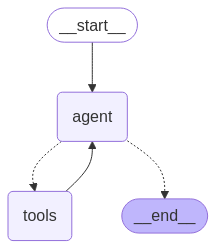

In [25]:
from IPython.display import Image, display

try:
    display(Image(learning_agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
config = {"configurable": {"user_id": "Kirushi", "thread_id": "1"}}

In [27]:
response = learning_agent.stream(
    {"messages": [
        {
            "role": "user",
            "content": "Hi! I'd like to start learning some basic Hindi vocabulary for my trip to India next month.",
        }
    ]}, 
    config=config,
    stream_mode="values",
)

for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I'd like to start learning some basic Hindi vocabulary for my trip to India next month.


================================== Ai Message ==================================

That's great, Kirushi! Let's start with some basic Hindi vocabulary that will be useful for your trip. I'll introduce some easy words and phrases that you can use in everyday situations. 

Let's begin with some common greetings and polite expressions.
Tool Calls:
  introduce_vocabulary (call_zalAvL9lvL4h5aC2y5my7GrE)
 Call ID: call_zalAvL9lvL4h5aC2y5my7GrE
  Args:
    topic: greetings
    difficulty: easy
    count: 5
    target_language: Hindi
================================= Tool Message =================================
Name: introduce_vocabulary

Here are 5 easy vocabulary words about greetings in Hindi:

1. Word: नमस्ते
   Transliteration: Namaste
   Translation: Hello
   Example: नमस्ते, आप कैसे हैं?
   Example Translation: Hello, how are you?
   Usage Note: "Namaste" is a common greeting in India, used in both formal and informal settings. It is often accompanied by a slight bow with hands pressed

In [28]:
print(event["messages"][-1].content)

Here are some basic Hindi greetings to get you started:

1. **नमस्ते (Namaste)** - Hello
   - Example: नमस्ते, आप कैसे हैं? (Hello, how are you?)
   - Note: "Namaste" is a common greeting in India, used in both formal and informal settings.

2. **अलविदा (Alvida)** - Goodbye
   - Example: अलविदा, फिर मिलेंगे। (Goodbye, we will meet again.)
   - Note: "Alvida" is used to bid farewell in everyday conversations.

3. **धन्यवाद (Dhanyavaad)** - Thank you
   - Example: आपके मदद के लिए धन्यवाद। (Thank you for your help.)
   - Note: A polite expression of gratitude.

4. **स्वागत (Swagat)** - Welcome
   - Example: हमारे घर में आपका स्वागत है। (Welcome to our home.)
   - Note: Used to warmly welcome someone.

5. **शुभ प्रभात (Shubh Prabhat)** - Good morning
   - Example: शुभ प्रभात, आज का दिन शुभ हो। (Good morning, may today be auspicious.)
   - Note: A formal morning greeting.

Would you like to practice these words with an exercise or learn more vocabulary?


In [29]:
response = learning_agent.stream(
    {"messages": [
        {
            "role": "user",
            "content": "Yes i like to practice these words!!",
        }
    ]}, 
    config=config,
    stream_mode="values",
)

for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yes i like to practice these words!!


================================== Ai Message ==================================
Tool Calls:
  create_practice_exercise (call_UNEHr5SHBwtlMDKsBQlCwUst)
 Call ID: call_UNEHr5SHBwtlMDKsBQlCwUst
  Args:
    exercise_type: translation
    difficulty: beginner
    topic: greetings
    target_language: Hindi
    recent_vocabulary: नमस्ते, अलविदा, धन्यवाद, स्वागत, शुभ प्रभात
================================= Tool Message =================================
Name: create_practice_exercise

**Beginner Level Hindi Translation Exercise: Greetings**

**Instructions:**
Translate the following English sentences into Hindi. Use the recently learned vocabulary items where appropriate. For the first item, an example answer is provided to guide you.

---

1. **Translate the following sentence into Hindi:**

   "Hello, how are you?"

   *Example Answer:* नमस्ते, आप कैसे हैं?

2. **Translate the following sentence into Hindi:**

   "Good morning, welcome to our home."

3. **Translate the following sentence i

In [31]:
print(event["messages"][-1].content)

Here's a translation exercise to practice the greetings you've learned:

**Translate the following English sentences into Hindi:**

1. "Hello, how are you?"
   - *Example Answer:* नमस्ते, आप कैसे हैं?

2. "Good morning, welcome to our home."

3. "Thank you for coming."

4. "Goodbye, see you soon."

5. "Hello, thank you for your help."

Feel free to write down your answers, and let me know if you'd like me to assess them or if you have any questions!


In [32]:
response = learning_agent.stream(
    {"messages": [
        {
            "role": "user",
            "content": "Wow Interesting!! 2) सुप्रभात, हमारे घर में आपका स्वागत है 3) आने के लिए धन्यवाद 4) Not sure... 5) नमस्ते, क्या आप मदद करने जा रहे हैं?",
        }
    ]}, 
    config=config,
    stream_mode="values",
)

for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Wow Interesting!! 2) सुप्रभात, हमारे घर में आपका स्वागत है 3) आने के लिए धन्यवाद 4) Not sure... 5) नमस्ते, क्या आप मदद करने जा रहे हैं?


================================== Ai Message ==================================
Tool Calls:
  assess_user_response (call_FVWhFz7LqeyDmeh28YaDXsdp)
 Call ID: call_FVWhFz7LqeyDmeh28YaDXsdp
  Args:
    exercise: Beginner Level Hindi Translation Exercise: Greetings

Instructions:
Translate the following English sentences into Hindi. Use the recently learned vocabulary items where appropriate. For the first item, an example answer is provided to guide you.

---

1. Translate the following sentence into Hindi:

   "Hello, how are you?"

   *Example Answer:* नमस्ते, आप कैसे हैं?

2. Translate the following sentence into Hindi:

   "Good morning, welcome to our home."

3. Translate the following sentence into Hindi:

   "Thank you for coming."

4. Translate the following sentence into Hindi:

   "Goodbye, see you soon."

5. Translate the following sentence into Hindi:

   "Hello, thank you for your help."

---

Answer Key:

1. नमस्ते, आप कैसे हैं?
2. शुभ प्रभात, हमारे घर में आपका स्वागत है।
3

In [33]:
print(event["messages"][-1].content)

Here's the feedback on your translations:

1. **नमस्ते, आप कैसे हैं?** - Correct! Well done!

2. **सुप्रभात, हमारे घर में आपका स्वागत है** - Almost correct! Just remember to use punctuation: **शुभ प्रभात, हमारे घर में आपका स्वागत है।**

3. **आने के लिए धन्यवाद** - Correct! Great job!

4. **Not sure...** - No worries! The correct translation is **अलविदा, फिर मिलेंगे।** ("Goodbye, see you soon.")

5. **नमस्ते, क्या आप मदद करने जा रहे हैं?** - This means "Hello, are you going to help?" The correct translation for "Hello, thank you for your help" is **नमस्ते, आपकी मदद के लिए धन्यवाद।**

You're doing great, Kirushi! Keep practicing, and you'll get more comfortable with these phrases. If you have any questions or want to try more exercises, just let me know! 😊


In [34]:
response = learning_agent.stream(
    {"messages": [
        {
            "role": "user",
            "content": "Thanks. Please store this information for the latter use.",
        }
    ]}, 
    config=config,
    stream_mode="values",
)

for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks. Please store this information for the latter use.


================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_guPxyn9GRLtWga2e6dubq3Ct)
 Call ID: call_guPxyn9GRLtWga2e6dubq3Ct
  Args:
    content: {'word': 'नमस्ते', 'translation': 'Hello', 'example_sentence': 'नमस्ते, आप कैसे हैं?', 'notes': 'Common greeting in India, used in both formal and informal settings.', 'difficulty': 'easy', 'confidence': 0.9, 'next_review': 7, 'review_count': 1}
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory 1391f4b0-4acd-4b5c-981a-58606e1fa353
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_N4xv6i2Zyym6bieTmC1A7Dij)
 Call ID: call_N4xv6i2Zyym6bieTmC1A7Dij
  Args:
    content: {'word': 'अलविदा', 'translation': 'Goodbye', 'example_sentence': 'अलविदा, फिर मिलेंगे।', 'notes': 'Used to bid farewell in everyday conversations.', 'difficulty': 'easy', 'confi

In [35]:
print(event["messages"][-1].content)

I've stored the vocabulary words and your progress for future reference. This will help us tailor your learning journey as you continue to practice and improve. If you have any more questions or need further assistance, feel free to ask! 😊
